# Getting started
This notebook is for me, Rakin, just to analyze the data. I avoided creating a .py file for this because I wanted to be able to use the notebook to write my thoughts and ideas. I will try to keep this notebook as clean as possible for anyone to jump in add their ideas to the project.

## Read & Clean the data 
Here the Data will be stored in Pandas checked for outliers, strange values etc before starting the preprocessing

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import random
import math

# Convert the Data CSV files to pandas
print("Reading Books Data...")
books_data = pd.read_csv("Data/BX-Books.csv", sep=';', on_bad_lines='skip', encoding="latin")
print("Readting Users Data...")
users_data = pd.read_csv("Data/BX-Users.csv", sep=';', on_bad_lines='skip', encoding="latin")
print("Reading Ratings Data...")
book_ratings = pd.read_csv("Data/BX-Book-Ratings.csv", sep=';', on_bad_lines='skip', encoding="latin")
print("Done!")

Reading Books Data...


C:\Users\rakin\AppData\Local\Temp\ipykernel_16336\1206900022.py:13: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_data = pd.read_csv("Data/BX-Books.csv", sep=';', on_bad_lines='skip', encoding="latin")


Readting Users Data...
Reading Ratings Data...
Done!


## Cleaning Books Data
Doing a massive cleaning of books_data.csv. 
1. Removing all the books that have no ISBN
2. Removing all the books that have no author
3. Removing all the books that have no title
4. Removing all the books that have no publisher
5. Removing all the books that have no year of publication or 0 as year of publication
6. Removing all the books that have no image url
7. Removing all the books that have no image url small
8. Removing all the books that have no image url medium
9. Removing all the books that have no image url large
10. Removing all books that have no description

In [2]:
# Find out which columns have mixed types
print("Total number of rows in the dataset is: ", len(books_data))
print("Total number of unique ISBNs is: ", len(books_data['ISBN'].unique()))

# In Book-Author, there are some values that are not strings. Drop their rows from the dataset
books_data = books_data.loc[books_data['Book-Author'].apply(lambda x: isinstance(x, str)), :]
books_data = books_data.loc[books_data['Year-Of-Publication'].apply(lambda x: isinstance(x, int)), :]
books_data = books_data.loc[books_data['Year-Of-Publication'].apply(lambda x: x != 0), :]
books_data = books_data.loc[books_data['Publisher'].apply(lambda x: isinstance(x, str)), :]
books_data = books_data.loc[books_data['Image-URL-S'].apply(lambda x: isinstance(x, str)), :]
books_data = books_data.loc[books_data['Image-URL-M'].apply(lambda x: isinstance(x, str)), :]
books_data = books_data.loc[books_data['Image-URL-L'].apply(lambda x: isinstance(x, str)), :]
books_data.dropna(inplace=True)
books_data.reset_index(drop=True, inplace=True)
print("Total number of rows in the dataset is: ", len(books_data))

# Grab all the ISBNs that been rated over 20 times in books_data
print("Delete all the ISBNs that have been rated less than 20 times from the dataset...")
ISBNs = book_ratings['ISBN'].value_counts()
ISBNs = ISBNs[ISBNs >= 20]
ISBNs = ISBNs.index.tolist()
books_data = books_data.loc[books_data['ISBN'].apply(lambda x: x in ISBNs), :]
books_data.reset_index(drop=True, inplace=True)
print("Books that have been rated more than 20 times: ", len(books_data))


Total number of rows in the dataset is:  271360
Total number of unique ISBNs is:  271360
Total number of rows in the dataset is:  202251
Delete all the ISBNs that have been rated less than 20 times from the dataset...
Books that have been rated more than 20 times:  7191


## Cleaning Book rating and User data

In [9]:
# Remove all ISBNs that were removed from books_data to book_ratings
print("Removing all the ISBNs that have been removed from the books_data dataset to the book_ratings dataset...")
valid_ISBNs = set(ISBNs)
book_ratings = book_ratings[book_ratings['ISBN'].isin(valid_ISBNs)].reset_index(drop=True)

# Remove the row from book_rating if a user rated a book a 0
print("Removing all the rows from book_ratings if a user rated a book a 0...")
nonzero_mask = book_ratings['Book-Rating'] != 0
book_ratings = book_ratings[nonzero_mask].reset_index(drop=True)

print("Removing all the users that have rated less than 5 books from the book_data dataset and their ISBN...")
users = book_ratings['User-ID'].value_counts()
users = users[users >= 4]
users = users.index.tolist()
book_ratings = book_ratings.loc[book_ratings['User-ID'].apply(lambda x: x in users), :]
book_ratings.reset_index(drop=True, inplace=True)
print("Total number of users that gave a rating of at leat 4 books is: ", len(users))


# If ISBN is in book_ratings and in books_data, keep it in books_data. Otherwise, drop it from books_data
ISBNs = None
ISBNs = book_ratings['ISBN'].value_counts()
ISBNs = ISBNs.index.tolist()
books_data = books_data.loc[books_data['ISBN'].apply(lambda x: x in ISBNs), :]
books_data.reset_index(drop=True, inplace=True)


Removing all the ISBNs that have been removed from the books_data dataset to the book_ratings dataset...
Removing all the rows from book_ratings if a user rated a book a 0...
Removing all the users that have rated less than 5 books from the book_data dataset and their ISBN...
Total number of users that gave a rating of at leat 4 books is:  8102


In [10]:
# Print out total books, users and ratings
print("Total books: ", len(books_data['ISBN'].unique()))
print("Total users: ", len(book_ratings['User-ID'].unique()))
print("Total ratings: ", len(book_ratings))

Total books:  7177
Total users:  8102
Total ratings:  108660


## Building the matrix for the recommendation system

In [29]:
# grab all the ISBNs in the books_data and user s in the book_ratings
ISBNs_filtered = books_data['ISBN'].unique().tolist()
users_filtered = book_ratings['User-ID'].unique().tolist()


# Create a dataframe where the Index is the User-ID and the columns are the ISBNs
print("Creating a dataframe where the Index is the User-ID and the columns are the ISBNs...")
matrix = pd.DataFrame(index=users_filtered, columns=ISBNs_filtered)
matrix.fillna(0, inplace=True)
print("The rows of the matrix are the users: ", matrix.shape[0])


# Fill the matrix with the ratings
for i in range(len(book_ratings)):
  user = book_ratings.iloc[i]['User-ID']
  ISBN = book_ratings.iloc[i]['ISBN']
  rating = book_ratings.iloc[i]['Book-Rating']
  matrix.at[user, ISBN] = rating

# Turn the NaN values to 0
matrix.fillna(0, inplace=True)


Creating a dataframe where the Index is the User-ID and the columns are the ISBNs...
The rows of the matrix are the users:  8102


C:\Users\rakin\AppData\Local\Temp\ipykernel_16336\2291586324.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  matrix.at[user, ISBN] = rating
C:\Users\rakin\AppData\Local\Temp\ipykernel_16336\2291586324.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  matrix.at[user, ISBN] = rating
C:\Users\rakin\AppData\Local\Temp\ipykernel_16336\2291586324.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

# Starting the collaborative filtering

First we are doing a cosine similarity matrix for the books. This will be used to find the most similar books to a given book and then recommend those books to the user.



Doing cosine similarity...
Visualizing the cosine_sim...


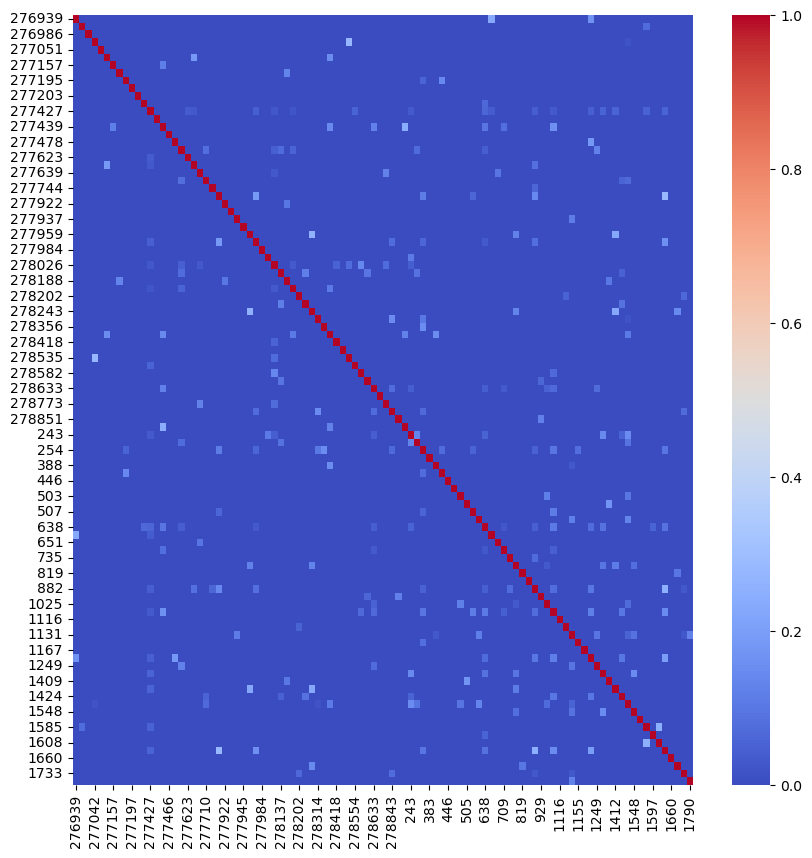

In [31]:
# Do cosine similarity
print("Doing cosine similarity...")
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(matrix, matrix)

# Turn the cosine_sim into a dataframe
cosine_sim = pd.DataFrame(cosine_sim, index=matrix.index, columns=matrix.index)

# Visualize the cosine_sim
print("Visualizing the cosine_sim...")
plt.figure(figsize=(10, 10))
sns.heatmap(cosine_sim.iloc[:100, :100], cmap='coolwarm')
plt.show()